In [2]:
import carla
import time
import pandas as pd
import random

# Connect to CARLA
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)
world = client.get_world()
time.sleep(5)  # Allow vehicles to spawn

# Get all vehicles
vehicles = world.get_actors().filter('vehicle.*')

# Initialize data storage
collision_data = []
collision_events = {}  # Dictionary to track collisions per vehicle

# Function to handle collision events
def collision_callback(event):
    vehicle_id = event.actor.id
    collision_events[vehicle_id] = True  # Mark vehicle as collided

# Attach collision sensors to vehicles
for vehicle in vehicles:
    blueprint = world.get_blueprint_library().find('sensor.other.collision')
    sensor = world.spawn_actor(blueprint, carla.Transform(), attach_to=vehicle)
    sensor.listen(collision_callback)
    collision_events[vehicle.id] = False  # Initialize as no collision

# Function to check for nearby vehicles with noise effects
def check_collision_behavior(vehicle, world):
    vehicle_list = world.get_actors().filter('vehicle.*')
    detected_vehicles = 0
    missed_detection = 0
    false_positive = 0
    collision_detected = collision_events.get(vehicle.id, False)  # Check collision status

    for other_vehicle in vehicle_list:
        if other_vehicle.id != vehicle.id:
            distance = vehicle.get_location().distance(other_vehicle.get_location())
            if distance < 15:  # Detection threshold
                detected_vehicles += 1

                # Simulating missed detection (20% probability)
                if random.random() < 0.2:
                    missed_detection += 1

    # Simulating false positives (10% probability)
    if random.random() < 0.1:
        false_positive = 1

    # Simulating decision delay (30% probability)
    if random.random() < 0.3:
        time.sleep(random.uniform(0.5, 2.0))  # Random delay between 0.5 and 2 seconds

    return detected_vehicles, missed_detection, false_positive, collision_detected

# Log data for 1 minute
start_time = time.time()
sampling_interval = 3.0  # Log every 3 seconds
last_logged_time = start_time

while time.time() - start_time < 60:  # Run for 1 minute
    world.tick()
    
    if time.time() - last_logged_time >= sampling_interval:
        last_logged_time = time.time()
        
        for vehicle in vehicles:
            detected, missed, false_alert, collision = check_collision_behavior(vehicle, world)
            collision_data.append({
                "vehicle_id": vehicle.id,
                "time": round(time.time() - start_time, 2),
                "detected_vehicles": detected,
                "missed_detection": missed,
                "false_positive": false_alert,
                "collision_detected": 1 if collision else 0
            })

# Save noisy collision data
df_collision = pd.DataFrame(collision_data)
df_collision.to_csv("collision_data_noisy.csv", index=False)

print("Noisy collision data saved!")


Noisy collision data saved!


In [4]:
import pandas as pd

# Load the datasets
df_base = pd.read_csv("collision_data_base.csv")
df_noisy = pd.read_csv("collision_data_noisy.csv")

# Display first few rows
print("Base collison manager Data:")
display(df_base.head())

print("Noisy collison manager Data:")
display(df_noisy.head())

# Check dataset shapes
print(f"Base Data Shape: {df_base.shape}, Noisy Data Shape: {df_noisy.shape}")


Base collison manager Data:


,vehicle_id,time,detected_vehicles,collision_detected
0,393,3.01,2,0
1,397,3.01,1,0
2,407,3.01,0,0
3,401,3.01,2,0
4,396,3.01,5,0


Noisy collison manager Data:


,vehicle_id,time,detected_vehicles,missed_detection,false_positive,collision_detected
0,494,4.96,1,0,0,0
1,474,4.96,1,0,0,0
2,482,4.96,1,0,0,0
3,480,4.96,1,1,0,0
4,500,4.97,1,0,0,0


Base Data Shape: (570, 4), Noisy Data Shape: (150, 6)


In [6]:
# Compute average detected vehicles per frame
avg_detected_base = df_base["detected_vehicles"].mean()
avg_detected_noisy = df_noisy["detected_vehicles"].mean()

# Handle missing columns gracefully
if "false_positive" in df_noisy.columns:
    false_positive_rate_noisy = df_noisy["false_positive"].mean() * 100
else:
    false_positive_rate_noisy = "N/A"

if "missed_detection" in df_noisy.columns:
    missed_detection_rate_noisy = df_noisy["missed_detection"].mean() * 100
else:
    missed_detection_rate_noisy = "N/A"

# Compute total collisions (exists in both datasets)
collisions_base = df_base["collision_detected"].sum()
collisions_noisy = df_noisy["collision_detected"].sum()

# Print the results
print(f"Base Avg Detected Vehicles: {avg_detected_base:.2f} | Noisy Avg Detected Vehicles: {avg_detected_noisy:.2f}")
print(f"Noisy False Positive Rate: {false_positive_rate_noisy}%")
print(f"Noisy Missed Detection Rate: {missed_detection_rate_noisy}%")
print(f"Base Collisions: {collisions_base} | Noisy Collisions: {collisions_noisy}")

Base Avg Detected Vehicles: 1.07 | Noisy Avg Detected Vehicles: 0.96
Noisy False Positive Rate: 14.000000000000002%
Noisy Missed Detection Rate: 22.666666666666664%
Base Collisions: 0 | Noisy Collisions: 5


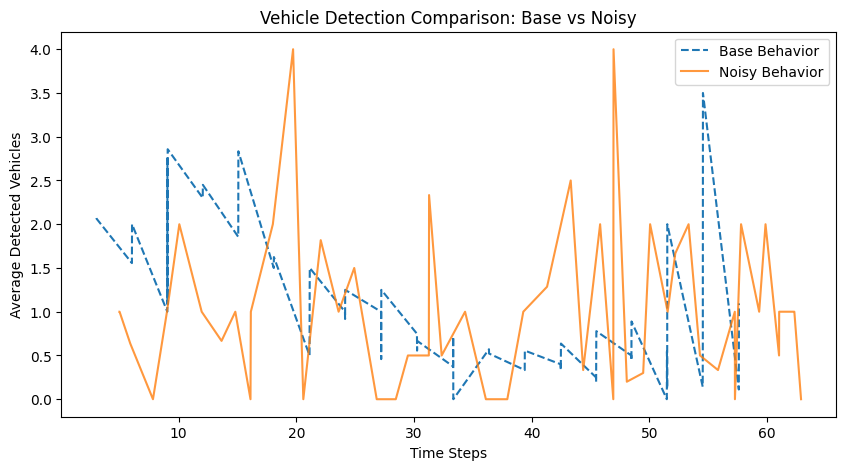

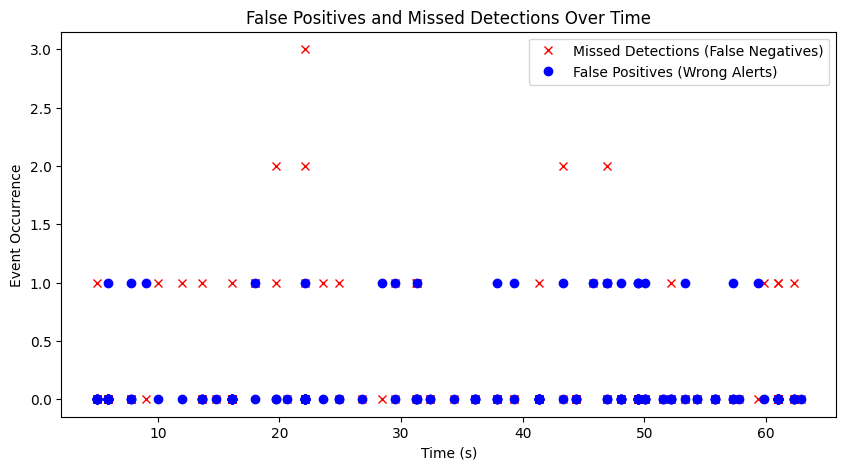

In [8]:
import matplotlib.pyplot as plt

# Compute average detected vehicles per time step
mean_detected_base = df_base.groupby("time")["detected_vehicles"].mean()
mean_detected_noisy = df_noisy.groupby("time")["detected_vehicles"].mean()

# Plot detected vehicles comparison
plt.figure(figsize=(10, 5))
plt.plot(mean_detected_base, label="Base Behavior", linestyle="dashed")
plt.plot(mean_detected_noisy, label="Noisy Behavior", alpha=0.8)
plt.xlabel("Time Steps")
plt.ylabel("Average Detected Vehicles")
plt.title("Vehicle Detection Comparison: Base vs Noisy")
plt.legend()
plt.show()

# Plot false positives & missed detections over time
plt.figure(figsize=(10, 5))
plt.plot(df_noisy["time"], df_noisy["missed_detection"], "rx", label="Missed Detections (False Negatives)")
plt.plot(df_noisy["time"], df_noisy["false_positive"], "bo", label="False Positives (Wrong Alerts)")
plt.xlabel("Time (s)")
plt.ylabel("Event Occurrence")
plt.title("False Positives and Missed Detections Over Time")
plt.legend()
plt.show()
